# This notebook outlines the data processing approach for the JOC article
    
To access the data and run the notebooks, you must perform the following steps:

1) Navigate to http://tiny.cc/JOC-XX-XXXX, where the XX-XXXX is the manuscript number on manuscript central.

2) Download the file, named data.tar.gz.  It has the following checksum information

![title](checksum.jpg)

3) ungz and untar the folder 'data' into the mcs_future folder. These files represent post-processed data and not the entire dataset.  This is due to the very large size of the three datasets, the raw derived data, and the amount of time it takes to run the training and classification.  However, applying the methods of this paper to the publically available data will give you the same results. If you downloaded the entire github project, the directories for the data folder and its subfolders should be:

/MCS/mcs_future/data/raw_data

/MCS/mcs_future/data/shapefiles

/MCS/mcs_future/data/slice_data

/MCS/mcs_future/data/wrf_data

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import sys
sys.path.append('C:/users/ahaberlie1/documents/github/MCS/')

data_dir = "../data/slice_data/"

data = {'mcs':{'OBS':None, 'CTRL':None, 'PGW':None},
        'qlcs':{'OBS':None, 'CTRL':None, 'PGW':None},
        'non_qlcs':{'OBS':None, 'CTRL':None, 'PGW':None}}

for subset in ['mcs', 'qlcs', 'non_qlcs']:
    
    filename = data_dir + "new_{}_project.csv".format(subset)
    
    df = pd.read_csv(filename)
    df['datetime'] = pd.to_datetime(df.datetime)
    df = df.set_index('datetime')
    
    for dataset in ['OBS', 'CTRL', 'PGW']:

        data[subset][dataset] = df[df.run.values==dataset].copy()

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

def draw_states(ax):
        
    shapename = 'admin_1_states_provinces_lakes_shp'
    states_shp = shpreader.natural_earth(resolution='50m',
                                     category='cultural', name=shapename)

    for state, info in zip(shpreader.Reader(states_shp).geometries(), shpreader.Reader(states_shp).records()):
        if info.attributes['admin'] == 'United States of America':

            ax.add_geometries([state], ccrs.PlateCarree(),
                              facecolor='None', edgecolor='k')
                              
def draw_midwest(ax):
    
    shapename = "../data/shapefiles/map/midwest_outline_latlon_grids"
    shp = shpreader.Reader(shapename)
    for outline, info in zip(shp.geometries(), shp.records()):
        ax.add_geometries([outline], ccrs.PlateCarree(),
                          facecolor='None', edgecolor='k', linewidth=4)
        
def generate_view(w_lon, e_lon, n_lat, s_lat, from_proj, to_proj):

    view = plt.axes([0,0,1,1], projection=to_proj)

    view.set_extent([w_lon, e_lon, s_lat, n_lat])

    shapename = 'admin_1_states_provinces_lakes_shp'
    states_shp = shpreader.natural_earth(resolution='50m',
                                         category='cultural', name=shapename)

    for state, info in zip(shpreader.Reader(states_shp).geometries(), shpreader.Reader(states_shp).records()):
        if info.attributes['admin'] == 'United States of America':

            view.add_geometries([state], ccrs.PlateCarree(),
                              facecolor='None', edgecolor='k')
            
    return view

# Draw all June - August OBS tracks

In [3]:
from netCDF4 import Dataset

#grid lats and lons
nc = Dataset("../data/wrf_data/RALconus4km_wrf_constants.nc")
lons = nc.variables['XLONG'][:,:]
lats = nc.variables['XLAT'][:,:]

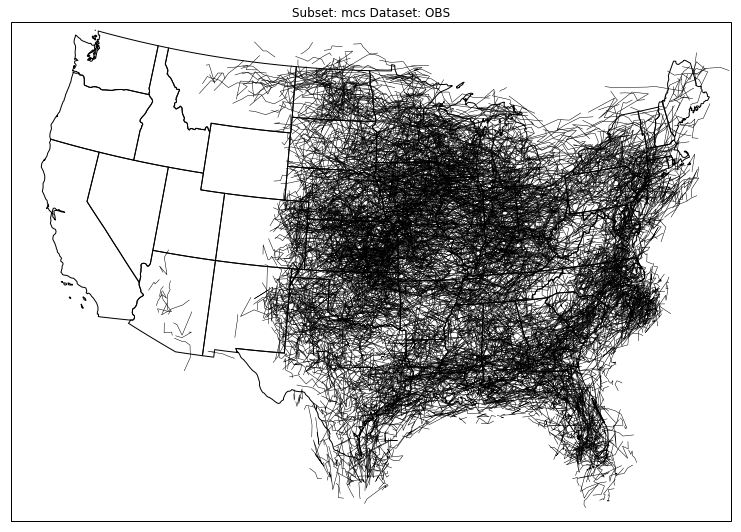

In [4]:
sys.path.append('C:/users/ahaberlie/documents/github/MCS/mcs_future')

import cartopy
import cartopy.crs as ccrs
from mcs_future.utils.mapping_help import wrf_to_lon_lat
import matplotlib.pyplot as plt
from netCDF4 import Dataset
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 10

from_proj = ccrs.PlateCarree()
to_proj = ccrs.AlbersEqualArea(central_longitude=-95, central_latitude=38.0000)

view = generate_view(-120, -73, 20, 50, from_proj, to_proj)

subset = 'mcs'
dataset = 'OBS'
df_ = data[subset][dataset].copy()
df_ = df_[df_.index.month.isin([6,7,8])]

for sid, swath in df_.groupby('storm_num'):

    xp = np.array([np.mean([x1, x2]) for (x1, x2) in zip(swath.xmin.values, swath.xmax.values)])
    yp = np.array([np.mean([y1, y2]) for (y1, y2) in zip(swath.ymin.values, swath.ymax.values)])

    xp, yp = wrf_to_lon_lat(lons, lats, xp.astype(int), yp.astype(int))

    view.plot(xp, yp, 'k-', lw=0.5, transform=from_proj)
    view.set_title("Subset: " + subset + " Dataset: " + dataset)

# Draw all June - August CTRL Tracks

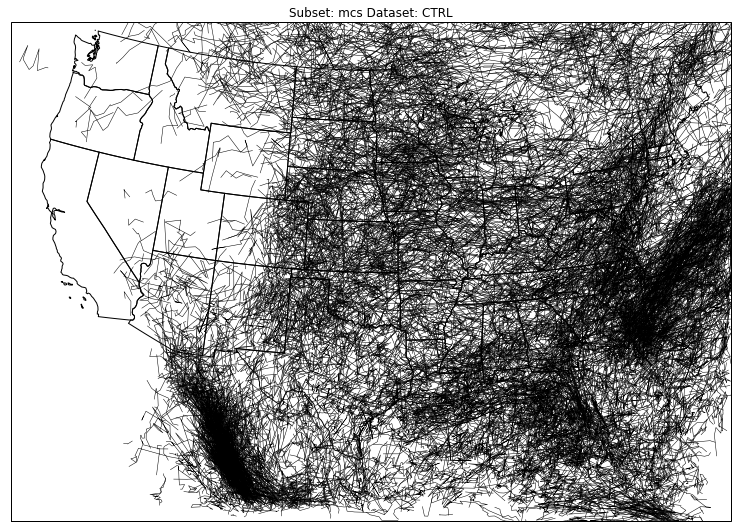

In [5]:
import cartopy
import cartopy.crs as ccrs
from mcs_future.utils.mapping_help import wrf_to_lon_lat
import matplotlib.pyplot as plt
from netCDF4 import Dataset
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 10

from_proj = ccrs.PlateCarree()
to_proj = ccrs.AlbersEqualArea(central_longitude=-95, central_latitude=38.0000)

view = generate_view(-120, -73, 20, 50, from_proj, to_proj)

subset = 'mcs'
dataset = 'CTRL'
df_ = data[subset][dataset]
df_ = df_[df_.index.month.isin([6,7,8])]

for sid, swath in df_.groupby('storm_num'):

    xp = np.array([np.mean([x1, x2]) for (x1, x2) in zip(swath.xmin.values, swath.xmax.values)])
    yp = np.array([np.mean([y1, y2]) for (y1, y2) in zip(swath.ymin.values, swath.ymax.values)])

    if dataset == 'OBS':
        xp, yp = NOWrad_to_lon_lat(xp, yp)
    else:
        xp, yp = wrf_to_lon_lat(lons, lats, xp.astype(int), yp.astype(int))

    view.plot(xp, yp, 'k-', lw=0.5, transform=from_proj)
    view.set_title("Subset: " + subset + " Dataset: " + dataset)

# Get only those tracks that are within the Midwest

In [6]:
import sys
import geopandas as gpd
from mcs_future.utils.mapping_help import get_point_subset

mw_shp_dir = "../data/shapefiles/map/"
wrf_dir = "../data/wrf_data/"
wrf_data_file = "RALconus4km_wrf_constants.nc"

mw_data = {'mcs':{'OBS':None, 'CTRL':None, 'PGW':None},
           'qlcs':{'OBS':None, 'CTRL':None, 'PGW':None},
           'non_qlcs':{'OBS':None, 'CTRL':None, 'PGW':None}}

outline = gpd.read_file(mw_shp_dir + "midwest_outline_latlon_grids.shp")

for sub_key, sub_value in data.items():
    
    for dset_key, dset_val in sub_value.items():
        mw_data[sub_key][dset_key] = get_point_subset(dset_val.copy(), 
                                                      outline, wrf_dir + wrf_data_file)

# Draw OBS QLCS tracks that are within the Midwest

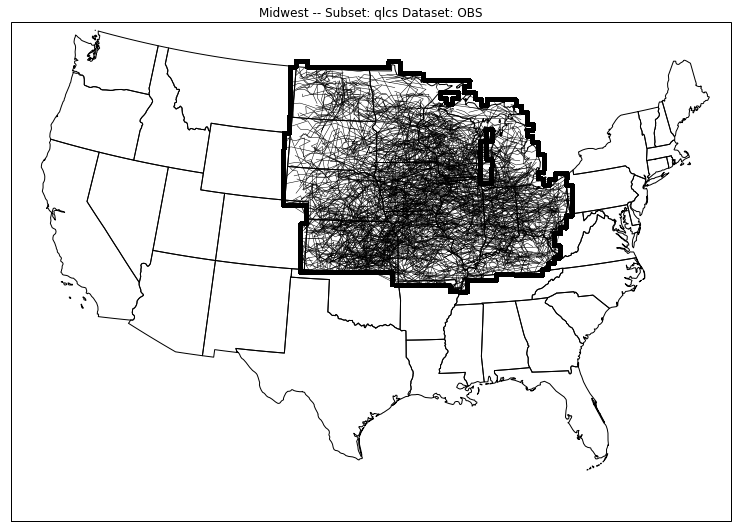

In [7]:
view = generate_view(-120, -73, 20, 50, from_proj, to_proj)

subset = 'qlcs'
dataset = 'OBS'
df_ = mw_data[subset][dataset].copy()
df_ = df_[df_.index.month.isin([6,7,8])]

for sid, swath in df_.groupby('storm_num'):

    xp = np.array([np.mean([x1, x2]) for (x1, x2) in zip(swath.xmin.values, swath.xmax.values)])
    yp = np.array([np.mean([y1, y2]) for (y1, y2) in zip(swath.ymin.values, swath.ymax.values)])

    xp, yp = wrf_to_lon_lat(lons, lats, xp.astype(int), yp.astype(int))

    view.plot(xp, yp, 'k-', lw=0.5, transform=from_proj)
    view.set_title("Midwest -- Subset: " + subset + " Dataset: " + dataset)
    
    draw_midwest(view)

# Draw CTRL QLCS tracks that intersect Midwest

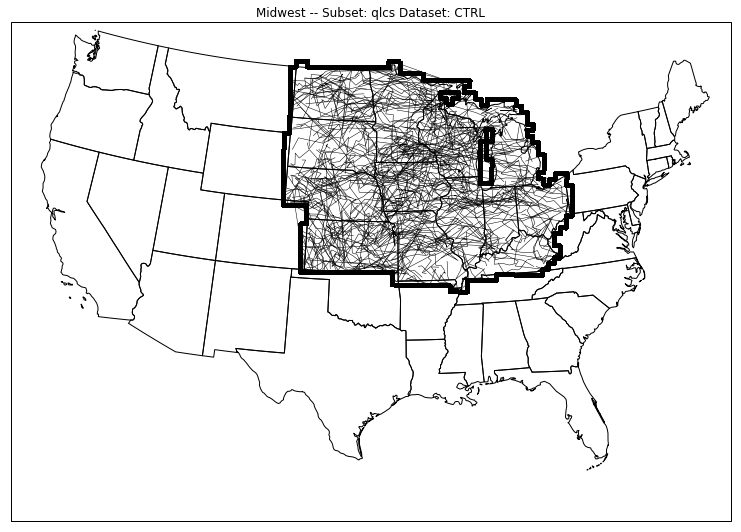

In [8]:
view = generate_view(-120, -73, 20, 50, from_proj, to_proj)

subset = 'qlcs'
dataset = 'CTRL'
df_ = mw_data[subset][dataset]
df_ = df_[df_.index.month.isin([6,7,8])]

for sid, swath in df_.groupby('storm_num'):

    xp = np.array([np.mean([x1, x2]) for (x1, x2) in zip(swath.xmin.values, swath.xmax.values)])
    yp = np.array([np.mean([y1, y2]) for (y1, y2) in zip(swath.ymin.values, swath.ymax.values)])

    if dataset == 'OBS':
        xp, yp = NOWrad_to_lon_lat(xp, yp)
    else:
        xp, yp = wrf_to_lon_lat(lons, lats, xp.astype(int), yp.astype(int))

    view.plot(xp, yp, 'k-', lw=0.5, transform=from_proj)
    view.set_title("Midwest -- Subset: " + subset + " Dataset: " + dataset)
    draw_midwest(view)

# Get counts of days from Midwest

In [9]:
import datetime
from scipy.misc import imread

def calc_day_count(dframe):
    
    #Resample and calculate how many rows each day has
    days = dframe.resample('D').count()
    
    #Give me the count of days with at least one row
    return np.sum(days['storm_num'].values > 0)

# Example of how Days vs. Event Counts Calculated

qlcs day counts: 6 ; percent of days examined: 1.0
qlcs swath counts: 10


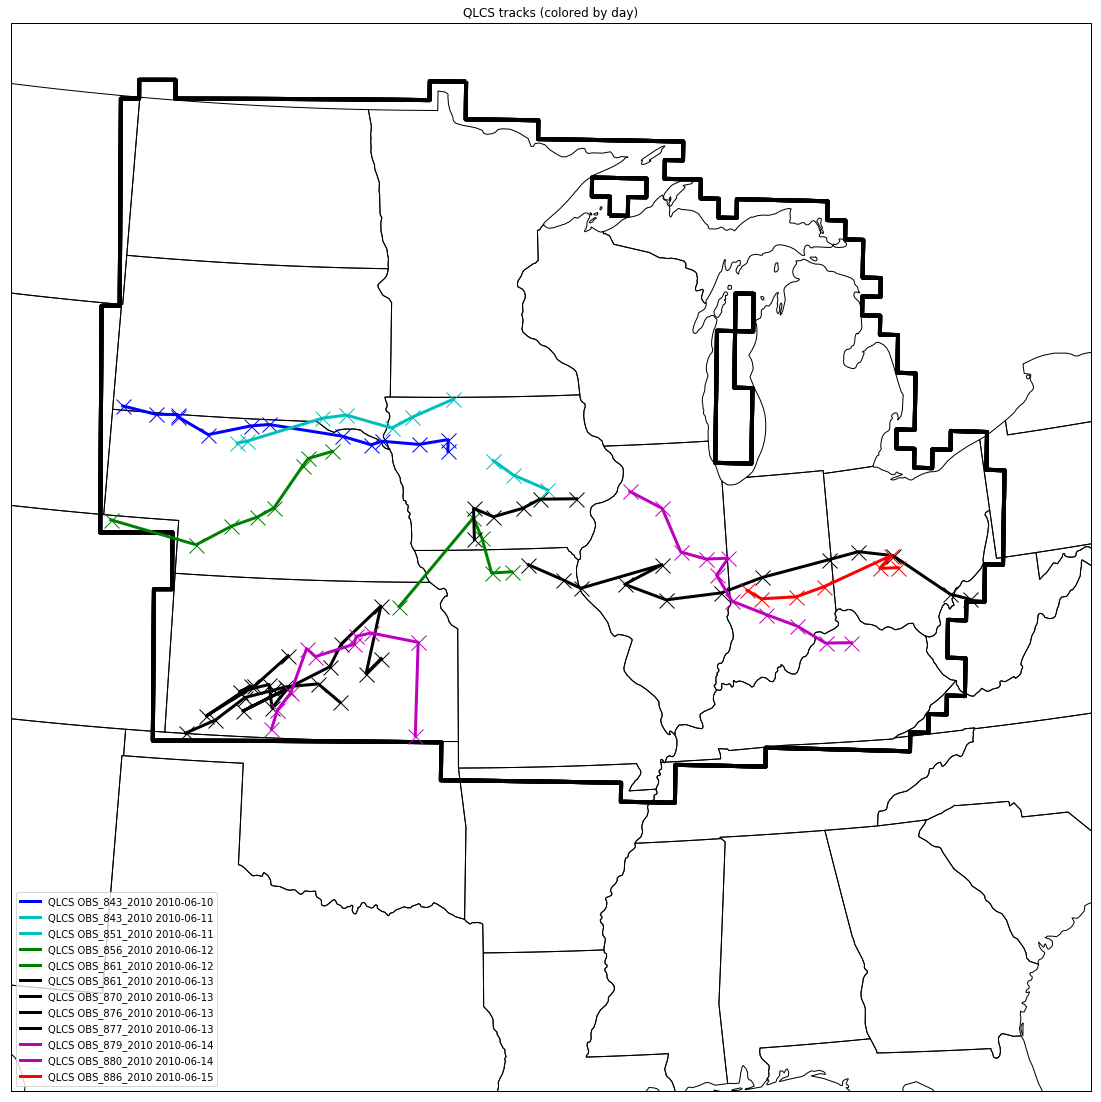

In [233]:
#Read in all observed qlcs events
dataset = 'OBS'
subset = 'qlcs'

#Read in a copy of this dataset.  This is important because
#we will be modifying the index (a datetime) to simplify the
#Day Count calculation
a = mw_data[subset][dataset].copy()

#Add 6 hours to the datetime so 18z is now centered at 00z
a.index = a.index + datetime.timedelta(hours=6)

#set year, month, and range of days
year = 2010
month = 6

#look at 
day_range = np.array(list(range(10, 16)))

#make temporary month/year dataframe
b = a[(a.index.year==year) & ((a.index.month==month)) & (a.index.day.isin(day_range))]

#try to select 8 or fewer days or this won't work that well
colors = ['b', 'c', 'g', 'k', 'm', 'r', 'grey', 'y']

lines = []
labels = []

#set up view centered on midwest
view = generate_view(-105, -80, 30, 50, from_proj, to_proj)

#plot tracks by day
for color, day in zip(colors, day_range):

    df_ = b[b.index.day==day]
    for sid, sw in df_.groupby('storm_num'):

        if len(sw) > 0:
            xp = np.array([np.mean([x1, x2]) for (x1, x2) in zip(sw.xmin.values, sw.xmax.values)])
            yp = np.array([np.mean([y1, y2]) for (y1, y2) in zip(sw.ymin.values, sw.ymax.values)])

            xp, yp = wrf_to_lon_lat(lons, lats, xp.astype(int), yp.astype(int))
            
            view.plot(xp, yp, 'x', markersize=15, color=color, transform=from_proj)

            view.plot(xp, yp, '-', lw=3, color=color, transform=from_proj, 
                      label=subset.upper() + " " + sid + " " + str(year) + "-" + str(month).zfill(2) + "-" + str(day).zfill(2))

    view.set_title(subset.upper() + " tracks (colored by day)")

    draw_midwest(view)

c = a[(a.index.year==year) & (a.index.month==month) & (a.index.day.isin(day_range))]

print(subset + " day counts:", calc_day_count(c), "; percent of days examined:", calc_day_count(c) / len(day_range))
print(subset + " swath counts:", c.storm_num.nunique())

view.legend(loc=3)

In [199]:
import numpy as np

for sub_key in ['mcs', 'qlcs', 'non_qlcs']:
    
    for dset_key in ['OBS', 'CTRL', 'PGW']:
        
        #copy the desired dataset and subset
        dset_val = mw_data[sub_key][dset_key].copy()
        
        #Get running count of slices per storm
        dset_val['storm_run'] = dset_val.groupby(['storm_num']).cumcount()
        
        #Shift 18z to 00z for analysis purposes
        dset_val.index = dset_val.index + datetime.timedelta(hours=6)
        
        total_count = calc_day_count(dset_val)
        
        seasons = {'djf':(12, 1, 2), 'mam':(3, 4, 5), 'jja':(6, 7, 8), 'son':(9, 10, 11)}
        
        for season_id, season_vals in seasons.items():
            
            dset_ = dset_val[dset_val.index.month.isin(season_vals)].copy()
            perc = "{0:.2f}".format(100*(calc_day_count(dset_) / total_count)) 
            seasons[season_id] = perc
        
        print(sub_key, dset_key, "Total Count:", total_count, 
              ", % DJF", seasons['djf'], ', % MAM', seasons['mam'], 
              ', % JJA', seasons['jja'], ', % SON', seasons['son'], '\n')    


mcs OBS Total Count: 1800 , % DJF 3.61 , % MAM 28.89 , % JJA 49.39 , % SON 18.11 

mcs CTRL Total Count: 1738 , % DJF 4.32 , % MAM 33.37 , % JJA 46.66 , % SON 15.65 

mcs PGW Total Count: 1850 , % DJF 6.76 , % MAM 35.14 , % JJA 38.59 , % SON 19.51 

qlcs OBS Total Count: 1200 , % DJF 3.67 , % MAM 28.25 , % JJA 52.42 , % SON 15.67 

qlcs CTRL Total Count: 743 , % DJF 3.90 , % MAM 38.49 , % JJA 44.15 , % SON 13.46 

qlcs PGW Total Count: 848 , % DJF 6.49 , % MAM 43.87 , % JJA 33.37 , % SON 16.27 

non_qlcs OBS Total Count: 1180 , % DJF 2.46 , % MAM 28.73 , % JJA 51.10 , % SON 17.71 

non_qlcs CTRL Total Count: 1445 , % DJF 3.60 , % MAM 31.76 , % JJA 49.69 , % SON 14.95 

non_qlcs PGW Total Count: 1584 , % DJF 6.25 , % MAM 34.09 , % JJA 40.66 , % SON 19.00 



# Show monthly percentages of events

In [12]:
from calendar import month_name as mname

col_names = ['key'] + [str(x) for x in range(1, 13)]

months = {x:[] for x in col_names}

for sub_key in ['mcs', 'qlcs', 'non_qlcs']:
    for dset_key in ['OBS', 'CTRL', 'PGW']:

        dset_val = mw_data[sub_key][dset_key].copy()
        
        #Shift 18z to 00z for analysis purposes
        dset_val.index = dset_val.index + datetime.timedelta(hours=6)
        
        #Total count of event days in each subset / dataset key pair
        total_count = calc_day_count(dset_val)

        for month in list(range(1, 13)):

            #only data from the particular month
            dset_ = dset_val[dset_val.index.month==month].copy()
            
            #append the percentage to the appropriate dictionary location
            months[str(month)].append(100*(calc_day_count(dset_) / total_count))
            
        
        months['key'].append(sub_key + "_" + dset_key)

df = pd.DataFrame.from_dict(months)
df = df.set_index('key')

for gid, group in df.groupby(df.index):
    
    max_idx = mname[int(group.idxmax(axis=1).values[0])]
    min_idx = mname[int(group.idxmin(axis=1).values[0])]
    
    max_val = group.max(axis=1).values[0]
    min_val = group.min(axis=1).values[0]
    
    print(gid, "\nMax Month:", max_idx, "\nMax Percentage:", "{:0.2f}".format(max_val), "%",
               "\nMin Month:", min_idx, "\nMin Percentage:", "{:0.2f}".format(min_val), "%", 
               "\nMax Percentage Diff", "{:0.2f}".format(max_val - min_val), "%\n")
    
df[col_names[1:]]

mcs_CTRL 
Max Month: June 
Max Percentage: 17.61 % 
Min Month: January 
Min Percentage: 1.27 % 
Max Percentage Diff 16.34 %

mcs_OBS 
Max Month: July 
Max Percentage: 16.83 % 
Min Month: December 
Min Percentage: 1.11 % 
Max Percentage Diff 15.72 %

mcs_PGW 
Max Month: June 
Max Percentage: 16.76 % 
Min Month: January 
Min Percentage: 1.89 % 
Max Percentage Diff 14.86 %

non_qlcs_CTRL 
Max Month: June 
Max Percentage: 18.34 % 
Min Month: January 
Min Percentage: 0.90 % 
Max Percentage Diff 17.44 %

non_qlcs_OBS 
Max Month: July 
Max Percentage: 18.81 % 
Min Month: February 
Min Percentage: 0.59 % 
Max Percentage Diff 18.22 %

non_qlcs_PGW 
Max Month: June 
Max Percentage: 16.79 % 
Min Month: January 
Min Percentage: 1.77 % 
Max Percentage Diff 15.03 %

qlcs_CTRL 
Max Month: June 
Max Percentage: 25.44 % 
Min Month: December 
Min Percentage: 1.08 % 
Max Percentage Diff 24.36 %

qlcs_OBS 
Max Month: June 
Max Percentage: 19.25 % 
Min Month: December 
Min Percentage: 0.92 % 
Max Percentag

,1,2,3,4,5,6,7,8,9,10,11,12
key,,,,,,,,,,,,
mcs_OBS,1.333333,1.166667,5.222222,9.500000,14.166667,16.722222,16.833333,15.833333,10.333333,5.277778,2.500000,1.111111
mcs_CTRL,1.265823,1.611047,6.271577,11.449942,15.650173,17.606444,15.937860,13.118527,7.364787,4.833142,3.452244,1.438435
mcs_PGW,1.891892,2.432432,7.675676,11.891892,15.567568,16.756757,12.054054,9.783784,8.324324,6.918919,4.270270,2.432432
qlcs_OBS,1.333333,1.416667,4.500000,8.833333,14.916667,19.250000,16.916667,16.250000,8.666667,4.750000,2.250000,0.916667
qlcs_CTRL,1.345895,1.480485,6.729475,11.843876,19.919246,25.437416,9.959623,8.748318,4.979812,5.652759,2.826380,1.076716
qlcs_PGW,1.886792,2.476415,8.254717,15.448113,20.165094,21.108491,7.311321,4.952830,6.014151,6.132075,4.127358,2.122642
non_qlcs_OBS,0.932203,0.593220,4.661017,9.661017,14.406780,15.593220,18.813559,16.694915,11.016949,4.745763,1.949153,0.932203
non_qlcs_CTRL,0.899654,1.384083,5.467128,10.657439,15.640138,18.339100,17.301038,14.048443,7.889273,3.875433,3.183391,1.314879
non_qlcs_PGW,1.767677,2.209596,6.944444,11.489899,15.656566,16.792929,13.194444,10.669192,8.522727,6.628788,3.851010,2.272727


# Draw cumulative count plots

3.5
JJA OBS:  mcs 69.33333333333334
JJA CTRL:  mcs 61.49999999999999
Jan-Sept OBS - CTRL Diff for: mcs 3.333333333333343
MAM OBS - CTRL Diff for: mcs -4.416666666666664
JJA OBS - CTRL Diff for: mcs 7.83333333333335
1.5
JJA OBS:  qlcs 49.08333333333333
JJA CTRL:  qlcs 25.25
Jan-Sept OBS - CTRL Diff for: qlcs 29.25
MAM OBS - CTRL Diff for: qlcs 4.416666666666668
JJA OBS - CTRL Diff for: qlcs 23.83333333333333
2.25
JJA OBS:  non_qlcs 47.16666666666667
JJA CTRL:  non_qlcs 54.33333333333333
Jan-Sept OBS - CTRL Diff for: non_qlcs -16.916666666666657
MAM OBS - CTRL Diff for: non_qlcs -8.916666666666668
JJA OBS - CTRL Diff for: non_qlcs -7.166666666666657


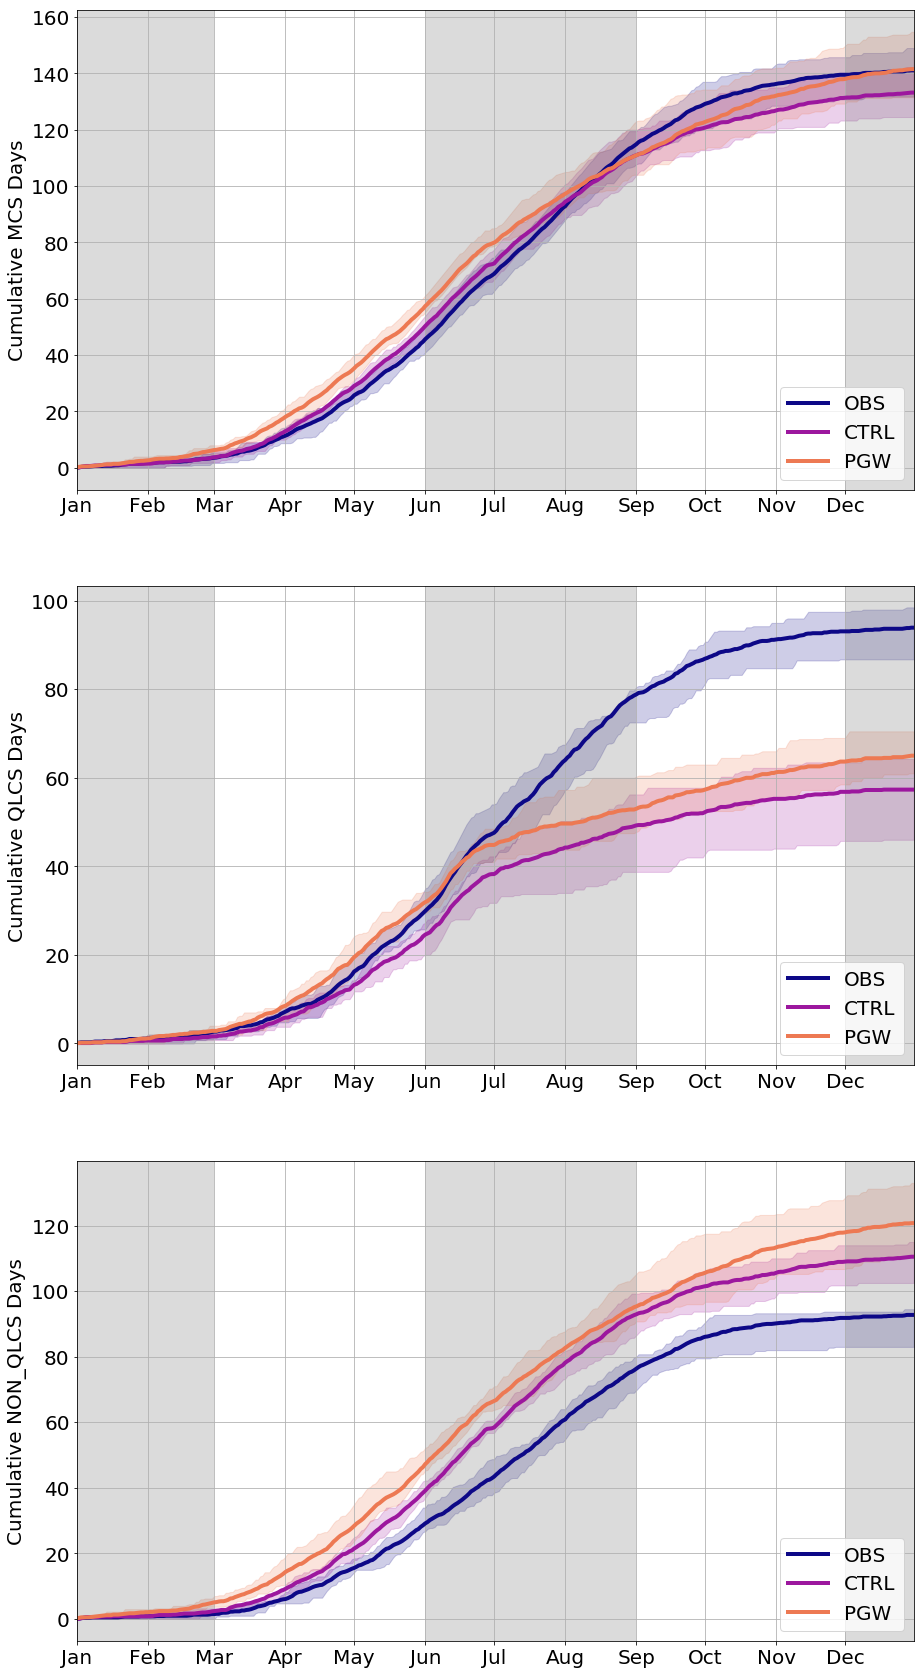

In [191]:
import datetime
from pandas.plotting import register_matplotlib_converters as pdtc
import matplotlib.dates as mdates
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
pdtc()
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = 15, 30
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.labelsize'] = 20

month_doy = {'Jan':1, 'Feb':32, 'Mar':60, 
             'Apr':91, 'May':121, 'Jun':152, 
             'Jul':182, 'Aug':213, 'Sep':244, 
             'Oct':274, 'Nov':305, 'Dec':335}

ax = plt.subplot(1, 1, 1)

drange = pd.date_range(start=datetime.datetime(2000, 10, 1), end=datetime.datetime(2013, 12, 31), freq='D')

colors = [plt.cm.plasma(x/3) for x in range(0, 3)]

def draw_cumu_labels(ax):
    
    ax.legend(loc=4, prop={'size': 20})
    
    ax.axvspan(datetime.datetime(2012, 1, 1), datetime.datetime(2012, 3, 1), facecolor='0.5', alpha=0.1)
    ax.axvspan(datetime.datetime(2012, 6, 1), datetime.datetime(2012, 9, 1), facecolor='0.5', alpha=0.1)
    ax.axvspan(datetime.datetime(2012, 12, 1), datetime.datetime(2012, 12, 31), facecolor='0.5', alpha=0.1)
    ax.grid()
    ax.set_ylabel("Cumulative Count")
    return ax

aug_obs = 0
may_obs = 0
feb_obs = 0

aug_ctrl = 0
may_ctrl = 0
feb_ctrl = 0

for subplot, subset in enumerate(['mcs', 'qlcs', 'non_qlcs']):
    ctrl_ = None
    obs_ = None
    maxyear = 0
    for dset_num, dataset in enumerate(['OBS', 'CTRL', 'PGW']):
        
        ax = plt.subplot(3, 1, subplot+1)
        
        #Get run and dataset from Midwest subset
        df_ = mw_data[subset][dataset].copy()
        df_.index = df_.index + datetime.timedelta(hours=6)
        df_ = df_[~((df_.index.year == 2000) | (df_.index.year == 2013))]
    
        years = df_.groupby(df_.index.year)

        dset = []

        for yid, year in years:

            a = year.resample('D').count()
            rng = pd.DataFrame(index=pd.date_range(start=str(yid) + '-01-01', end=str(yid) + '-12-31', freq='1D'))
            rng = rng.join(a[['storm_num']])
            rng = rng.fillna(0)
            rng['storm_num'] = 1*(rng['storm_num'].values>0)

            dset.append(rng.cumsum())

        dset = pd.concat(dset)
        dset['doy'] = dset.index.dayofyear

        p25 = []
        p75 = []
        mean = []
        for did, doy in dset.groupby('doy'):
            p25.append(np.percentile(doy.storm_num, 25, interpolation='linear'))
            p75.append(np.percentile(doy.storm_num, 75, interpolation='linear'))
            mean.append(np.mean(doy.storm_num))

        mean[-1] = mean[-2]
        p25[-1] = p25[-2]
        p75[-1] = p75[-2]
        
        ax.fill_between(rng.index.to_pydatetime(), p25, p75, color=colors[dset_num], alpha=0.2)
        ax.plot(rng.index.to_pydatetime(), mean, '-', color=colors[dset_num], linewidth=4, label=dataset)
        draw_cumu_labels(ax)
        
        if dataset == 'OBS':
            aug_obs = dset[(dset.index.month==8) & (dset.index.day==31)]['storm_num'].mean()
            
            feb_obs = []
            for year in range(2001, 2013):

                if year not in [2004, 2008, 2012]:
                    feb_obs.append(dset[(dset.index.year==year) & 
                                        (dset.index.month==2) & 
                                        (dset.index.day==28)]['storm_num'].values[0])
                else:
                    feb_obs.append(dset[(dset.index.year==year) & 
                                        (dset.index.month==2) & 
                                        (dset.index.day==29)]['storm_num'].values[0])
                
            feb_obs = np.mean(feb_obs)
                
            may_obs = dset[(dset.index.month==5) & (dset.index.day==31)]['storm_num'].mean()
            
        elif dataset == 'CTRL':
            aug_ctrl = dset[(dset.index.month==8) & (dset.index.day==31)]['storm_num'].mean()
            
            feb_ctrl = []
            for year in range(2001, 2013):

                if year not in [2004, 2008, 2012]:
                    feb_ctrl.append(dset[(dset.index.year==year) & 
                                        (dset.index.month==2) & 
                                        (dset.index.day==28)]['storm_num'].values[0])
                else:
                    feb_ctrl.append(dset[(dset.index.year==year) & 
                                        (dset.index.month==2) & 
                                        (dset.index.day==29)]['storm_num'].values[0])
                
            feb_ctrl = np.mean(feb_ctrl)
                
            may_ctrl = dset[(dset.index.month==5) & (dset.index.day==31)]['storm_num'].mean()

    jan_sep_dif_obs = aug_obs
    mar_may_dif_obs = may_obs - feb_obs
    aug_jun_dif_obs = aug_obs - may_obs
    
    jan_sep_dif_ctrl = aug_ctrl
    mar_may_dif_ctrl = may_ctrl - feb_ctrl
    aug_jun_dif_ctrl = aug_ctrl - may_ctrl
    
    print("JJA OBS: ", subset, aug_jun_dif_obs)
    print("JJA CTRL: ", subset, aug_jun_dif_ctrl)
    
    print("Jan-Sept OBS - CTRL Diff for:", subset, jan_sep_dif_obs - jan_sep_dif_ctrl)
    print("MAM OBS - CTRL Diff for:", subset, mar_may_dif_obs - mar_may_dif_ctrl)
    print("JJA OBS - CTRL Diff for:", subset, aug_jun_dif_obs - aug_jun_dif_ctrl)
        
    ax.set_xlim(rng.index[0], rng.index[-1])
    ax.set_ylabel("Cumulative " + subset.upper() + " Days", fontsize=20)
    locator = mdates.MonthLocator()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    
plt.savefig("Figure1.tif", dpi=400, bbox_inches='tight')

# Calculate hourly percentages (JJA)

In [16]:
col_names = ['key'] + [str(x) for x in range(0, 24)]

hours = {x:[] for x in col_names}

for sub_key in ['mcs', 'qlcs', 'non_qlcs']:
    for dset_key in ['OBS', 'CTRL', 'PGW']:

        dset_val = mw_data[sub_key][dset_key].copy()
        dset_val = dset_val[dset_val.index.month.isin([6,7,8])]
        total_count = 1196

        for hr in list(range(0, 24)):
            
            dset_ = dset_val[dset_val.index.hour==hr]
            
            hours[str(hr)].append(100*(calc_day_count(dset_) / total_count))
            
        hours['key'].append(sub_key + "_" + dset_key)

df = pd.DataFrame.from_dict(hours)
df = df.set_index('key')

for gid, group in df.groupby(df.index):
    
    max_idx = group.idxmax(axis=1).values[0]
    min_idx = group.idxmin(axis=1).values[0]
    
    max_val = group.max(axis=1).values[0]
    min_val = group.min(axis=1).values[0]
    
    print(gid, "\nMax:", max_idx.zfill(2), "z - Max %", max_val, 
               "\nMin:", min_idx.zfill(2), "z - Min %", min_val, '\nMax % Diff', max_val - min_val, '\n')
df

mcs_CTRL 
Max: 03 z - Max % 39.046822742474916 
Min: 17 z - Min % 16.806020066889634 
Max % Diff 22.240802675585282 

mcs_OBS 
Max: 07 z - Max % 47.82608695652174 
Min: 19 z - Min % 18.645484949832774 
Max % Diff 29.180602006688968 

mcs_PGW 
Max: 03 z - Max % 31.605351170568564 
Min: 17 z - Min % 17.224080267558527 
Max % Diff 14.381270903010037 

non_qlcs_CTRL 
Max: 03 z - Max % 27.675585284280935 
Min: 17 z - Min % 11.2876254180602 
Max % Diff 16.387959866220733 

non_qlcs_OBS 
Max: 08 z - Max % 19.39799331103679 
Min: 19 z - Min % 7.441471571906355 
Max % Diff 11.956521739130434 

non_qlcs_PGW 
Max: 03 z - Max % 23.662207357859533 
Min: 17 z - Min % 11.538461538461538 
Max % Diff 12.123745819397994 

qlcs_CTRL 
Max: 03 z - Max % 16.722408026755854 
Min: 16 z - Min % 6.270903010033445 
Max % Diff 10.45150501672241 

qlcs_OBS 
Max: 07 z - Max % 33.11036789297659 
Min: 17 z - Min % 12.290969899665551 
Max % Diff 20.81939799331104 

qlcs_PGW 
Max: 05 z - Max % 13.461538461538462 
Min: 

,0,1,10,11,12,13,14,15,16,17,...,21,22,23,3,4,5,6,7,8,9
key,,,,,,,,,,,,,,,,,,,,,
mcs_OBS,34.448161,38.377926,43.311037,40.301003,37.625418,33.779264,30.267559,25.836120,22.324415,20.066890,...,24.749164,28.177258,31.354515,41.889632,44.565217,45.484950,46.822742,47.826087,46.822742,44.732441
mcs_CTRL,35.953177,38.628763,26.086957,25.334448,22.826087,20.903010,18.979933,17.391304,17.307692,16.806020,...,26.421405,28.344482,33.528428,39.046823,37.374582,35.033445,34.531773,32.525084,30.769231,27.926421
mcs_PGW,28.929766,30.016722,26.923077,24.581940,24.163880,23.244147,21.655518,19.481605,18.645485,17.224080,...,20.986622,24.665552,26.337793,31.605351,31.270903,30.685619,29.347826,28.177258,27.257525,27.424749
qlcs_OBS,24.080268,27.675585,28.511706,25.167224,22.575251,20.234114,17.558528,14.966555,12.876254,12.290970,...,15.301003,18.561873,21.571906,30.183946,32.023411,32.274247,33.026756,33.110368,32.274247,30.183946
qlcs_CTRL,14.464883,15.886288,10.869565,9.782609,8.779264,7.608696,6.772575,6.354515,6.270903,6.438127,...,9.113712,10.284281,12.959866,16.722408,16.220736,15.635452,14.548495,14.130435,13.043478,11.872910
qlcs_PGW,10.702341,11.287625,11.454849,10.200669,9.197324,8.612040,8.444816,7.190635,7.107023,6.438127,...,7.107023,8.026756,10.200669,12.374582,12.709030,13.461538,12.959866,13.127090,13.377926,12.541806
non_qlcs_OBS,12.959866,14.966555,18.060201,18.561873,17.642140,15.384615,14.632107,12.374582,10.200669,8.612040,...,11.204013,11.956522,12.207358,16.137124,17.558528,17.725753,18.561873,19.230769,19.397993,18.394649
non_qlcs_CTRL,25.752508,27.508361,17.391304,17.140468,15.468227,14.464883,13.043478,11.956522,11.705686,11.287625,...,19.397993,21.153846,23.996656,27.675585,26.421405,24.247492,23.745819,21.488294,20.150502,18.227425
non_qlcs_PGW,21.070234,22.240803,18.143813,17.056856,17.391304,16.471572,14.632107,13.545151,12.290970,11.538462,...,15.301003,18.311037,18.394649,23.662207,22.742475,21.237458,19.648829,17.809365,17.391304,18.143813


# Calculate hourly min/max differences in Days per year (JJA) 

In [198]:
shrs = [str(x) for x in range(0, 24)]
col_names = ['subset', 'dset'] + shrs

hours = {x:[] for x in col_names}

for sub_key in ['mcs', 'qlcs', 'non_qlcs']:
    for dset_key in ['OBS', 'CTRL', 'PGW']:

        dset_val = mw_data[sub_key][dset_key].copy()
        dset_val = dset_val[dset_val.index.month.isin([6,7,8])].copy()
        total_count = 1196

        for hr in list(range(0, 24)):
            
            dset_ = dset_val[dset_val.index.hour==hr].copy()
            
            hours[str(hr)].append(calc_day_count(dset_))
            
        hours['subset'].append(sub_key)
        hours['dset'].append(dset_key)

df = pd.DataFrame.from_dict(hours)

for sset in ['mcs', 'qlcs', 'non_qlcs']:
    
    obs = df[(df.dset=='OBS') & (df.subset==sset)]
    ctrl = df[(df.dset=='CTRL') & (df.subset==sset)]
    
    diff = np.abs(obs[shrs].values - ctrl[shrs].values)
    
    max_idx = np.argmax(diff)
    min_idx = np.argmin(diff)
    
    max_val = np.max(diff) / 13
    min_val = np.min(diff) / 13
    
    print(sset, "\nMax:", max_idx, "z - Max ", max_val, 
               "\nMin:", min_idx, "z - Min ", min_val)

print("\nTotals")
print("\n", df[col_names[:10]])
print("\n", df[col_names[:2] + col_names[10:18]])
print("\n", df[col_names[:2] + col_names[18:]])

mcs 
Max: 10 z - Max  15.846153846153847 
Min: 22 z - Min  0.15384615384615385
qlcs 
Max: 8 z - Max  17.692307692307693 
Min: 19 z - Min  5.230769230769231
non_qlcs 
Max: 0 z - Max  11.76923076923077 
Min: 9 z - Min  0.15384615384615385

Totals

      subset  dset    0    1    2    3    4    5    6    7
0       mcs   OBS  412  459  488  501  533  544  560  572
1       mcs  CTRL  430  462  466  467  447  419  413  389
2       mcs   PGW  346  359  367  378  374  367  351  337
3      qlcs   OBS  288  331  343  361  383  386  395  396
4      qlcs  CTRL  173  190  190  200  194  187  174  169
5      qlcs   PGW  128  135  144  148  152  161  155  157
6  non_qlcs   OBS  155  179  197  193  210  212  222  230
7  non_qlcs  CTRL  308  329  326  331  316  290  284  257
8  non_qlcs   PGW  252  266  271  283  272  254  235  213

      subset  dset    8    9   10   11   12   13   14   15
0       mcs   OBS  560  535  518  482  450  404  362  309
1       mcs  CTRL  368  334  312  303  273  250  227  2

# Draw hourly counts of events

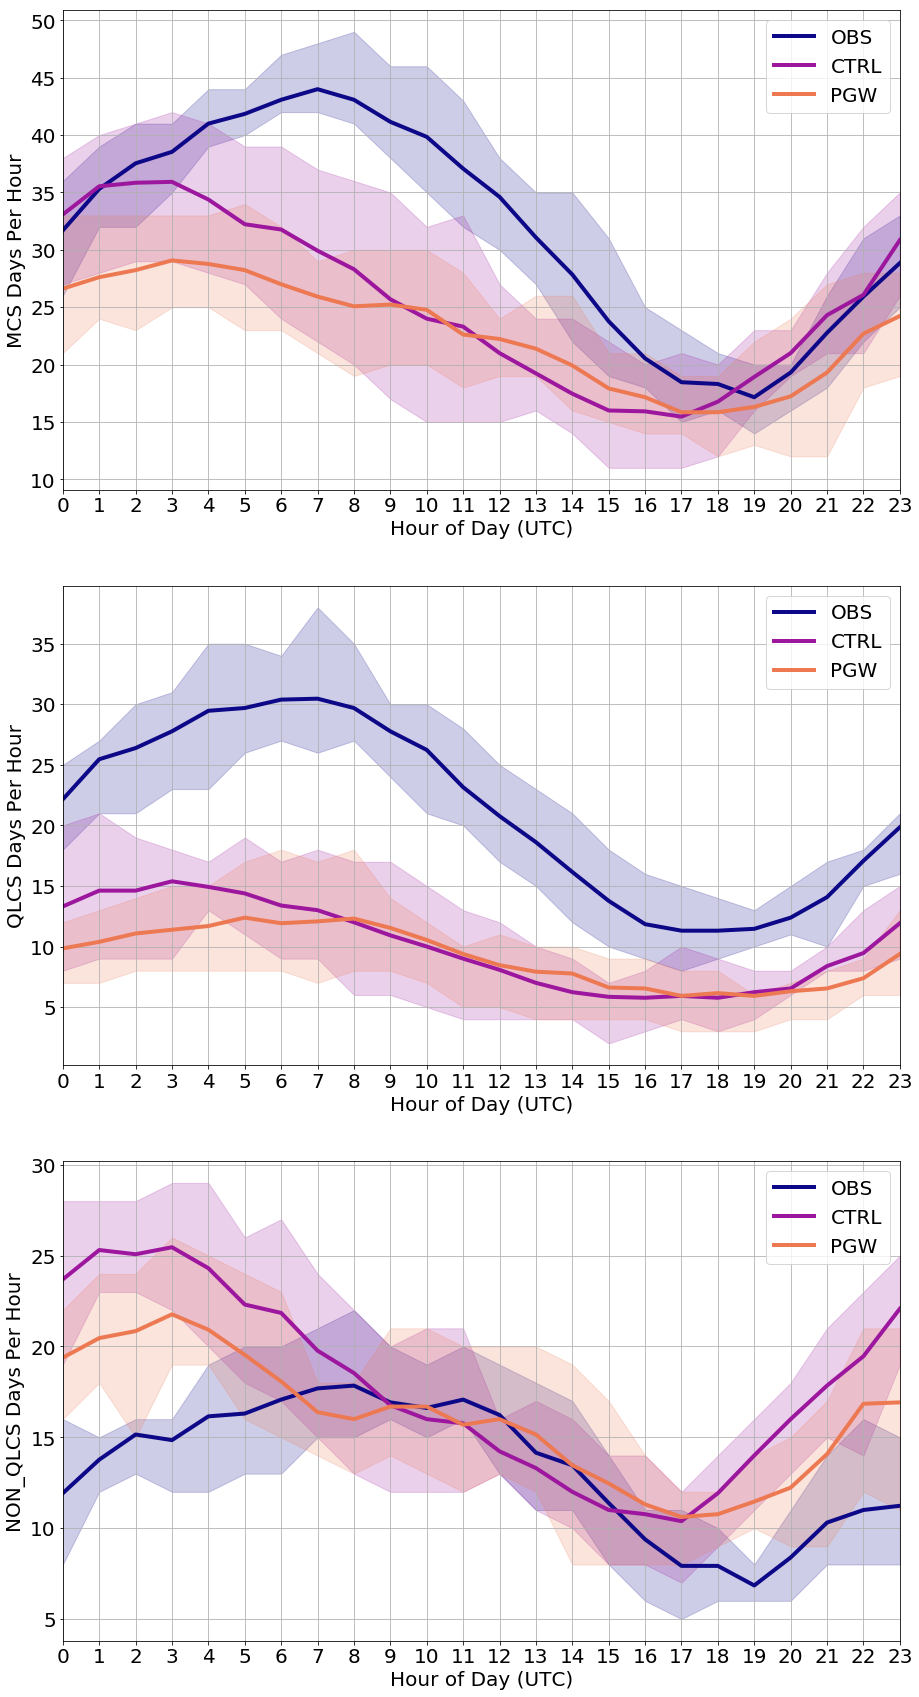

In [20]:
plt.rcParams['figure.figsize'] = 15, 30
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.labelsize'] = 20

def draw_hour_labels(ax, lab):
    ax.set_xlim(0, 23)
    ax.legend(prop={'size': 20})

    ax.set_ylabel(lab + " Days Per Hour")
    ax.set_xlabel("Hour of Day (UTC)")
    ax.set_xticks(list(range(0, 24)))
    #ax.set_title(lab + " Swath Count by Hour of Day", fontsize=20)
    ax.grid()

colors = [plt.cm.plasma(x/3) for x in range(0, 3)]

for subplot, subset in enumerate(['mcs', 'qlcs', 'non_qlcs']):
    for dset_num, dataset in enumerate(['OBS', 'CTRL', 'PGW']):
        
        ax = plt.subplot(3, 1, subplot+1)
        
        df_ = mw_data[subset][dataset].copy()
        df_ = df_[df_.index.month.isin([6,7,8])].copy()

        years = df_.groupby(df_.index.year)
        year_data = np.zeros((13, 24), dtype=int)
        
        for yid, year in years:
            hour_data = []
            for hid in range(0, 24):

                hour = year[year.index.hour==hid]
                hour_data.append(calc_day_count(hour))
                
            year_data[yid-2001, :] = np.array(hour_data)

        p25 = np.percentile(year_data, 25, axis=0)
        p75 = np.percentile(year_data, 75, axis=0)
        plt.fill_between(list(range(24)), p25, p75, color=colors[dset_num], alpha=0.2)
        plt.plot(np.mean(year_data, axis=0), '-', color=colors[dset_num], linewidth=4, label=dataset)
        
        ax = draw_hour_labels(ax, subset.upper())
        
plt.savefig("Figure2.tif", dpi=400, bbox_inches='tight')